In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow" # you can also use tensorflow or torch

import keras_cv
import keras
from keras import ops
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import joblib

import matplotlib.pyplot as plt 

2024-04-07 19:28:54.988683: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 19:28:54.988826: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 19:28:55.123595: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasCV:", keras_cv.__version__)

TensorFlow: 2.15.0
Keras: 3.0.5
KerasCV: 0.8.2


In [3]:
class CFG:
    verbose = 1  # Verbosity
    seed = 42  # Random seed
    preset = "efficientnetv2_b2_imagenet"  # Name of pretrained classifier
    image_size = [400, 300]  # Input image size
    epochs = 13 # Training epochs
    batch_size = 64  # Batch size
    lr_mode = "cos" # LR scheduler mode from one of "cos", "step", "exp"
    drop_remainder = True  # Drop incomplete batches
    num_classes = 1 # Number of classes in the dataset
    fold = 0 # Which fold to set as validation data
    class_names = ['Seizure']
    label2name = dict(enumerate(class_names))
    name2label = {v:k for k, v in label2name.items()}

In [4]:
keras.utils.set_random_seed(CFG.seed)

## Load in data

In [5]:
BASE_PATH = "/kaggle/input/hms-harmful-brain-activity-classification"

SPEC_DIR = "/tmp/dataset/hms-hbac"
os.makedirs(SPEC_DIR+'/train_spectrograms', exist_ok=True)
os.makedirs(SPEC_DIR+'/test_spectrograms', exist_ok=True)

In [6]:
# Train + Valid
df = pd.read_csv(f'{BASE_PATH}/train.csv')
df['eeg_path'] = f'{BASE_PATH}/train_eegs/'+df['eeg_id'].astype(str)+'.parquet'
df['spec_path'] = f'{BASE_PATH}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.parquet'
df['spec2_path'] = f'{SPEC_DIR}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.npy'
df['class_name'] = df.expert_consensus.copy()
df['class_label'] = df.expert_consensus.map(CFG.name2label)
display(df.head(2))

# Test
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')
test_df['eeg_path'] = f'{BASE_PATH}/test_eegs/'+test_df['eeg_id'].astype(str)+'.parquet'
test_df['spec_path'] = f'{BASE_PATH}/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.parquet'
test_df['spec2_path'] = f'{SPEC_DIR}/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.npy'
display(test_df.head(2))

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,spec2_path,class_name,class_label
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/train_spectrograms/35373...,Seizure,0.0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/train_spectrograms/35373...,Seizure,0.0


,spectrogram_id,eeg_id,patient_id,eeg_path,spec_path,spec2_path
0,853520,3911565283,6885,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/test_spectrograms/853520...


## Set binary class label

In [7]:
df['seizure_binary'] = np.where(df.expert_consensus == 'Seizure',1,0)

In [8]:
df.seizure_binary.value_counts()

seizure_binary
0    85867
1    20933
Name: count, dtype: int64

## Create cross val splits

In [9]:
from sklearn.model_selection import StratifiedGroupKFold

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=CFG.seed)

df["fold"] = -1
df.reset_index(drop=True, inplace=True)
for fold, (train_idx, valid_idx) in enumerate(
    sgkf.split(df, y=df["seizure_binary"], groups=df["patient_id"])
):
    df.loc[valid_idx, "fold"] = fold
df.groupby(["fold", "class_name"])[["eeg_id"]].count().T

fold           0                                     1                    ...  \
class_name   GPD  GRDA   LPD  LRDA Other Seizure   GPD  GRDA   LPD  LRDA  ...   
eeg_id      2705  2824  2901  3715  3987    3897  3249  4401  1178  4189  ...   

fold           3                         4                                  
class_name   LPD  LRDA Other Seizure   GPD  GRDA   LPD  LRDA Other Seizure  
eeg_id      1765  2317  3314    3470  2201  3258  5484  3117  3756    4295  

[1 rows x 30 columns]

## Data processing

In [10]:
# Define a function to process a single eeg_id
def process_spec(spec_id, split="train"):
    spec_path = f"{BASE_PATH}/{split}_spectrograms/{spec_id}.parquet"
    spec = pd.read_parquet(spec_path)
    spec = spec.fillna(0).values[:, 1:].T # fill NaN values with 0, transpose for (Time, Freq) -> (Freq, Time)
    spec = spec.astype("float32")
    np.save(f"{SPEC_DIR}/{split}_spectrograms/{spec_id}.npy", spec)

# Get unique spec_ids of train and valid data
spec_ids = df["spectrogram_id"].unique()

# Parallelize the processing using joblib for training data
_ = joblib.Parallel(n_jobs=-1, backend="loky")(
    joblib.delayed(process_spec)(spec_id, "train")
    for spec_id in tqdm(spec_ids, total=len(spec_ids))
)

# Get unique spec_ids of test data
test_spec_ids = test_df["spectrogram_id"].unique()

# Parallelize the processing using joblib for test data
_ = joblib.Parallel(n_jobs=-1, backend="loky")(
    joblib.delayed(process_spec)(spec_id, "test")
    for spec_id in tqdm(test_spec_ids, total=len(test_spec_ids))
)

  0%|          | 0/11138 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

## Create augmenter (not used for now) and build dataset

In [11]:
def build_augmenter(dim=CFG.image_size):
    augmenters = [
        keras_cv.layers.MixUp(alpha=2.0),
        keras_cv.layers.RandomCutout(height_factor=(1.0, 1.0),
                                     width_factor=(0.06, 0.1)), # freq-masking
        keras_cv.layers.RandomCutout(height_factor=(0.06, 0.1),
                                     width_factor=(1.0, 1.0)), # time-masking
    ]
    
    def augment(img, label):
        data = {"images":img, "labels":label}
        for augmenter in augmenters:
            if tf.random.uniform([]) < 0.5:
                data = augmenter(data, training=True)
        return data["images"], data["labels"]
    
    return augment


def build_decoder(with_labels=True, target_size=CFG.image_size, dtype=32):
    def decode_signal(path, offset=None):
        # Read .npy files and process the signal
        file_bytes = tf.io.read_file(path)
        sig = tf.io.decode_raw(file_bytes, tf.float32)
        sig = sig[1024//dtype:]  # Remove header tag
        sig = tf.reshape(sig, [400, -1])
        
        # Extract labeled subsample from full spectrogram using "offset"
        if offset is not None: 
            offset = offset // 2  # Only odd values are given
            sig = sig[:, offset:offset+300]
            
            # Pad spectrogram to ensure the same input shape of [400, 300]
            pad_size = tf.math.maximum(0, 300 - tf.shape(sig)[1])
            sig = tf.pad(sig, [[0, 0], [0, pad_size]])
            sig = tf.reshape(sig, [400, 300])
        
        # Log spectrogram 
        sig = tf.clip_by_value(sig, tf.math.exp(-4.0), tf.math.exp(8.0)) # avoid 0 in log
        sig = tf.math.log(sig)
        
        # Normalize spectrogram
        sig -= tf.math.reduce_mean(sig)
        sig /= tf.math.reduce_std(sig) + 1e-6
        
        # Mono channel to 3 channels to use "ImageNet" weights
        sig = tf.tile(sig[..., None], [1, 1, 3])
        return sig
    
    def decode_label(label):
        label = tf.one_hot(label, CFG.num_classes)
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [CFG.num_classes])
        return label
    
    def decode_with_labels(path, offset=None, label=None):
        sig = decode_signal(path, offset)
        label = decode_label(label)
        return (sig, label)
    
    return decode_with_labels if with_labels else decode_signal


def build_dataset(paths, offsets=None, labels=None, batch_size=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=False, repeat=True, shuffle=1024, 
                  cache_dir="", drop_remainder=False):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter()
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = (paths, offsets) if labels is None else (paths, offsets, labels)
    
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

In [12]:
sample_df = df.groupby("spectrogram_id").head(1).reset_index(drop=True)
train_df = sample_df[sample_df.fold != CFG.fold]
valid_df = sample_df[sample_df.fold == CFG.fold]
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

# Train
train_paths = train_df.spec2_path.values
train_offsets = train_df.spectrogram_label_offset_seconds.values.astype(int)
train_labels = train_df.seizure_binary.values
train_ds = build_dataset(train_paths, train_offsets, train_labels, batch_size=CFG.batch_size,
                         repeat=True, shuffle=True, augment=True, cache=True)

# Valid
valid_paths = valid_df.spec2_path.values
valid_offsets = valid_df.spectrogram_label_offset_seconds.values.astype(int)
valid_labels = valid_df.seizure_binary.values
valid_ds = build_dataset(valid_paths, valid_offsets, valid_labels, batch_size=CFG.batch_size,
                         repeat=False, shuffle=False, augment=False, cache=True)

# Num Train: 8950 | Num Valid: 2188


## Start modeling

In [13]:
#baseline model: predict dominant class
accuracies = []
for fold in df.fold.unique():
    train = df[df.fold != fold]
    val = df[df.fold == fold]
    if np.mean(train.seizure_binary) >= 0.5:
        pred = 1
    else:
        pred = 0
    accuracy = sum(np.where(val.seizure_binary == pred,1,0))/len(val)
    accuracies.append(accuracy)
print('crossval accuracies:',accuracies)
print('mean crossval accuracy:',np.mean(accuracies))

crossval accuracies: [0.8057527927276017, 0.809474182851729, 0.8054321234210395, 0.839789463964172, 0.7602210954273446]
mean crossval accuracy: 0.8041339316783773


In [14]:
LOSS = keras.losses.BinaryCrossentropy()

In [15]:
#model 2: simple logistic regression
tf.keras.backend.clear_session()

model = keras.Sequential()

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(
  units=1,                     
  use_bias=True,               
  activation="sigmoid"         
))

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

model.compile(loss='binary_crossentropy', 
            optimizer=optimizer, 
            metrics=[LOSS])

In [16]:
history = model.fit(
  train_ds, 
  epochs=5,
  steps_per_epoch=len(train_df)//CFG.batch_size,
  validation_data=valid_ds, 
  verbose=CFG.verbose           
  )

Epoch 1/5
  2/139 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - binary_crossentropy: 83.3371 - loss: 83.3371

I0000 00:00:1712518340.269291     114 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


139/139 ━━━━━━━━━━━━━━━━━━━━ 46s 311ms/step - binary_crossentropy: 852.1757 - loss: 852.1757 - val_binary_crossentropy: 633.0804 - val_loss: 633.0804
Epoch 2/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 28s 204ms/step - binary_crossentropy: 615.4246 - loss: 615.4246 - val_binary_crossentropy: 2044.4141 - val_loss: 2044.4141
Epoch 3/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 26s 188ms/step - binary_crossentropy: 630.5466 - loss: 630.5466 - val_binary_crossentropy: 350.1932 - val_loss: 350.1932
Epoch 4/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 27s 194ms/step - binary_crossentropy: 570.7534 - loss: 570.7534 - val_binary_crossentropy: 170.3134 - val_loss: 170.3134
Epoch 5/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 26s 190ms/step - binary_crossentropy: 545.9724 - loss: 545.9724 - val_binary_crossentropy: 564.0197 - val_loss: 564.0197


In [17]:
from sklearn.metrics import accuracy_score,f1_score
val_preds = np.rint(model.predict(valid_ds))

print('val accuracy:',accuracy_score(valid_labels,val_preds))
print('val f1:',f1_score(valid_labels,val_preds))

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step
val accuracy: 0.18327239488117003
val f1: 0.2703144140465496


**Jailynne Model**

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer

model = Sequential([
    InputLayer(shape=(CFG.image_size[0], CFG.image_size[1], 3)),  
    Conv2D(16, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # For binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [19]:
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=CFG.epochs,
    steps_per_epoch=len(train_df) // CFG.batch_size,
    validation_steps=len(valid_df) // CFG.batch_size,
    verbose=CFG.verbose
)


Epoch 1/13


2024-04-07 19:35:00.920102: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 8.06233, expected 7.1186
2024-04-07 19:35:00.920181: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 7.45623, expected 6.5125
2024-04-07 19:35:00.920204: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 7.87881, expected 6.93508
2024-04-07 19:35:00.920217: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 8.40568, expected 7.46195
2024-04-07 19:35:00.920230: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 7.7167, expected 6.77297
2024-04-07 19:35:00.920243: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 7.94927, expected 7.00554
2024-04-07 19:35:00.920253: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 6.85259, expected 5.90886
2024-04-07 19:35:00.920264: E external/local_xla/xla/servi

139/139 ━━━━━━━━━━━━━━━━━━━━ 48s 203ms/step - accuracy: 0.6937 - loss: 5.1326 - val_accuracy: 0.8019 - val_loss: 0.6174
Epoch 2/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.7442 - loss: 0.5690

2024-04-07 19:36:09.442081: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 118793: 3.88607, expected 3.35474
2024-04-07 19:36:09.442196: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 121186: 4.31261, expected 3.78128
2024-04-07 19:36:09.442214: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 121187: 4.23125, expected 3.69992
2024-04-07 19:36:09.442231: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 121977: 4.25937, expected 3.72804
2024-04-07 19:36:09.442249: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 123091: 3.78513, expected 3.2538
2024-04-07 19:36:09.442284: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 126567: 4.28531, expected 3.75398
2024-04-07 19:36:09.442301: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 127167: 4.04113, expected 3.5098
2024-04-07 19:36:09.44

139/139 ━━━━━━━━━━━━━━━━━━━━ 29s 210ms/step - accuracy: 0.7442 - loss: 0.5690 - val_accuracy: 0.8333 - val_loss: 0.4758
Epoch 3/13
  2/139 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.8125 - loss: 0.6771

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


139/139 ━━━━━━━━━━━━━━━━━━━━ 27s 195ms/step - accuracy: 0.7686 - loss: 0.5574 - val_accuracy: 0.8267 - val_loss: 0.4539
Epoch 4/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 26s 185ms/step - accuracy: 0.7456 - loss: 0.4667 - val_accuracy: 0.8333 - val_loss: 0.5949
Epoch 5/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 29s 210ms/step - accuracy: 0.7533 - loss: 0.4497 - val_accuracy: 0.8254 - val_loss: 0.4048
Epoch 6/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 26s 186ms/step - accuracy: 0.7565 - loss: 0.4377 - val_accuracy: 0.8333 - val_loss: 0.6100
Epoch 7/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 28s 198ms/step - accuracy: 0.7629 - loss: 0.4343 - val_accuracy: 0.8373 - val_loss: 0.3978
Epoch 8/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 38s 278ms/step - accuracy: 0.7557 - loss: 0.4239 - val_accuracy: 0.8333 - val_loss: 0.7264
Epoch 9/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 29s 207ms/step - accuracy: 0.7409 - loss: 0.4381 - val_accuracy: 0.8401 - val_loss: 0.3830
Epoch 10/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 27s 195ms/step - accuracy: 0.7621 - loss: 0.4111 - va

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

val_predictions = model.predict(valid_ds, batch_size=32)
val_predictions = np.round(val_predictions).astype(int)

# True labels
true_labels = valid_labels 

print(classification_report(true_labels, val_predictions))
print(confusion_matrix(true_labels, val_predictions))


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step
              precision    recall  f1-score   support

           0       0.12      0.01      0.01      1783
           1       0.15      0.78      0.25       405

    accuracy                           0.15      2188
   macro avg       0.14      0.39      0.13      2188
weighted avg       0.12      0.15      0.06      2188

[[  12 1771]
 [  89  316]]


**Addressing Class Imbalance**

In [21]:
from sklearn.utils import class_weight
import numpy as np

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels)
class_weight_dict = dict(enumerate(class_weights))

# Configure the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

# Train the model with class weights
history = model.fit(
    train_ds,
    epochs=CFG.epochs,
    steps_per_epoch=len(train_df) // CFG.batch_size,
    validation_data=valid_ds,
    validation_steps=len(valid_df) // CFG.batch_size,
    class_weight=class_weight_dict,  
    verbose=CFG.verbose)

Epoch 1/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 35s 192ms/step - accuracy: 0.7617 - loss: 0.6209 - val_accuracy: 0.8336 - val_loss: 0.9126
Epoch 2/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.7515 - loss: 0.5960

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


139/139 ━━━━━━━━━━━━━━━━━━━━ 39s 279ms/step - accuracy: 0.7515 - loss: 0.5962 - val_accuracy: 0.8333 - val_loss: 0.5572
Epoch 3/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 27s 192ms/step - accuracy: 0.7619 - loss: 0.5597 - val_accuracy: 0.8143 - val_loss: 0.4573
Epoch 4/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 25s 183ms/step - accuracy: 0.7397 - loss: 0.5924 - val_accuracy: 0.7500 - val_loss: 8.0164
Epoch 5/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 29s 209ms/step - accuracy: 0.7418 - loss: 0.5654 - val_accuracy: 0.8139 - val_loss: 0.4364
Epoch 6/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 26s 185ms/step - accuracy: 0.7457 - loss: 0.5761 - val_accuracy: 0.8333 - val_loss: 0.7519
Epoch 7/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 28s 200ms/step - accuracy: 0.7498 - loss: 0.5309 - val_accuracy: 0.8143 - val_loss: 0.4965
Epoch 8/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 27s 195ms/step - accuracy: 0.7400 - loss: 0.5729 - val_accuracy: 0.8333 - val_loss: 0.9548
Epoch 9/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 30s 213ms/step - accuracy: 0.7288 - loss: 0.6024 - val

**Data augmentation**

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen_args = {
    'rotation_range': 20,  # degrees
    'width_shift_range': 0.2,  # fraction of total width
    'height_shift_range': 0.2,  # fraction of total height
    'zoom_range': 0.2,
    'horizontal_flip': True,
    'vertical_flip': True,
    'fill_mode': 'nearest'
}

image_data_generator = ImageDataGenerator(**data_gen_args)


In [23]:
def augment_image(image, label):
    # Randomly flip the image horizontally
    image = tf.image.random_flip_left_right(image)

    # Randomly flip the image vertically
    image = tf.image.random_flip_up_down(image)

    # Randomly change the brightness of the image
    image = tf.image.random_brightness(image, max_delta=0.1)

    # Randomly change the contrast of the image
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)

    image = tf.clip_by_value(image, 0.0, 1.0)
    
    return image, label


In [24]:
# Apply the augmentation only to the training dataset
augmented_train_ds = train_ds.map(augment_image)


In [25]:
history = model.fit(
    augmented_train_ds,
    validation_data=valid_ds,
    epochs=CFG.epochs,
    steps_per_epoch=len(train_df) // CFG.batch_size,
    validation_steps=len(valid_df) // CFG.batch_size
)


Epoch 1/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 79s 531ms/step - accuracy: 0.7317 - loss: 1.3869 - val_accuracy: 0.7123 - val_loss: 0.7103
Epoch 2/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 80s 578ms/step - accuracy: 0.7357 - loss: 0.5645 - val_accuracy: 0.6667 - val_loss: 2.8025
Epoch 3/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 70s 508ms/step - accuracy: 0.7551 - loss: 0.4921 - val_accuracy: 0.8038 - val_loss: 0.9662
Epoch 4/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 80s 576ms/step - accuracy: 0.7361 - loss: 0.4819 - val_accuracy: 0.7500 - val_loss: 0.8866
Epoch 5/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 71s 511ms/step - accuracy: 0.7353 - loss: 0.4813 - val_accuracy: 0.8001 - val_loss: 1.3369
Epoch 6/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 69s 500ms/step - accuracy: 0.7478 - loss: 0.4797 - val_accuracy: 0.8333 - val_loss: 1.3324
Epoch 7/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 72s 519ms/step - accuracy: 0.7478 - loss: 0.4851 - val_accuracy: 0.7895 - val_loss: 1.4492
Epoch 8/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 70s 507ms/step - accuracy: 0.7361 - loss: 0

2024-04-07 20:04:41.163724: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 118707: 5.11719, expected 4.49613
2024-04-07 20:04:41.163787: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 118794: 4.32811, expected 3.70705
2024-04-07 20:04:41.163797: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 118917: 5.07404, expected 4.45299
2024-04-07 20:04:41.163806: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 119273: 4.82557, expected 4.20452
2024-04-07 20:04:41.163815: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 119414: 4.87272, expected 4.25166
2024-04-07 20:04:41.163823: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 119417: 5.1557, expected 4.53464
2024-04-07 20:04:41.163832: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 119485: 4.79207, expected 4.17102
2024-04-07 20:04:41.1

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step


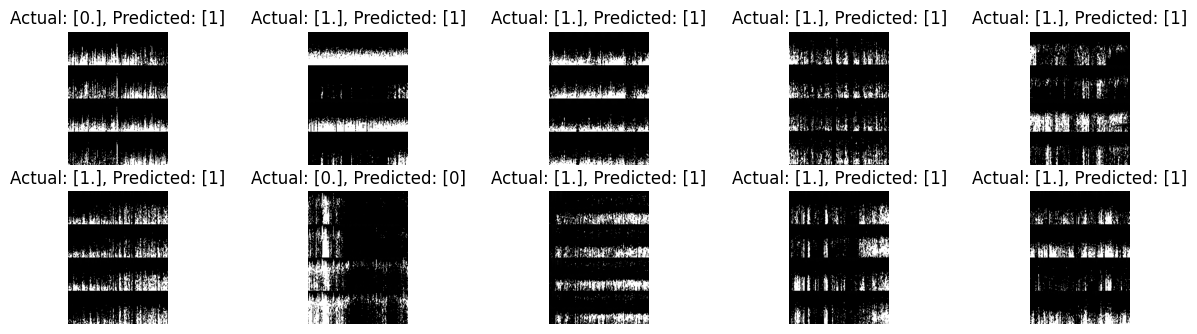

In [26]:
import matplotlib.pyplot as plt
import tensorflow as tf

def display_predictions(dataset, model, num_images=10):
    plt.figure(figsize=(15, 10))
    for images, labels in dataset.take(1):
        preds = model.predict(images)
        preds = np.round(preds).astype(int)
        for i in range(num_images):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype('uint8'))
            plt.title(f"Actual: {labels[i].numpy()}, Predicted: {preds[i]}")
            plt.axis('off')
    plt.show()

display_predictions(valid_ds, model, num_images=10)


In [27]:
# Evaluate the model on the entire validation dataset
val_loss, val_accuracy = model.evaluate(valid_ds)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

from sklearn.metrics import classification_report

y_true = np.concatenate([y for x, y in valid_ds], axis=0)
y_pred = model.predict(valid_ds)
y_pred = np.round(y_pred).astype(int)

print(classification_report(y_true, y_pred))


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8043 - loss: 0.5545
Validation Loss: 0.5637564659118652
Validation Accuracy: 0.7989031076431274
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
              precision    recall  f1-score   support

         0.0       0.11      0.01      0.02       405
         1.0       0.81      0.98      0.89      1783

    accuracy                           0.80      2188
   macro avg       0.46      0.49      0.46      2188
weighted avg       0.68      0.80      0.73      2188



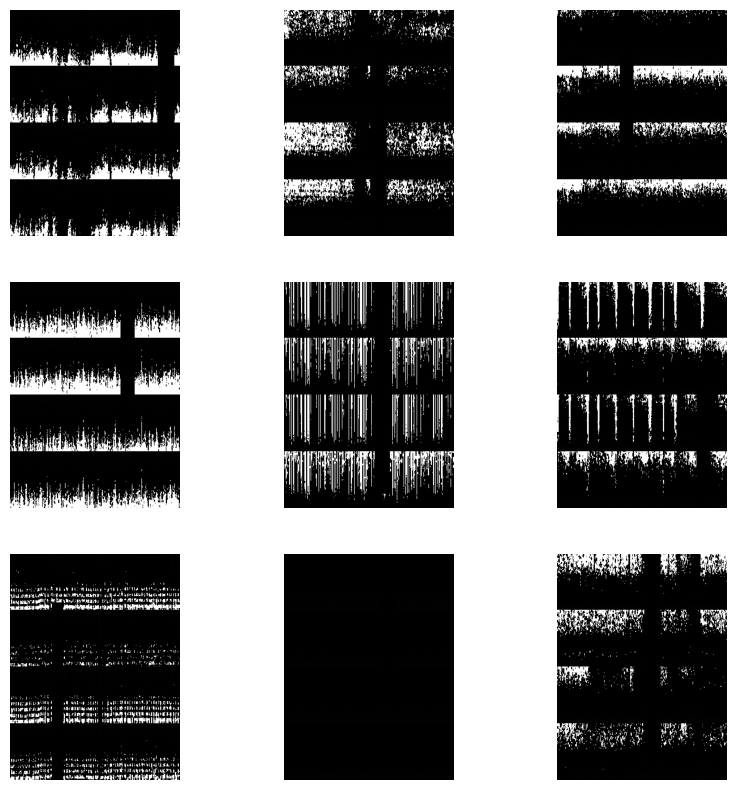

Epoch 1/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 64s 406ms/step - accuracy: 0.7492 - loss: 0.4775 - val_accuracy: 0.8125 - val_loss: 0.4987
Epoch 2/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 55s 401ms/step - accuracy: 0.7373 - loss: 0.4722 - val_accuracy: 0.8333 - val_loss: 0.4508
Epoch 3/13
  1/139 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.6719 - loss: 0.5023

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


139/139 ━━━━━━━━━━━━━━━━━━━━ 56s 403ms/step - accuracy: 0.7605 - loss: 0.4745 - val_accuracy: 0.8189 - val_loss: 0.4500
Epoch 4/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 54s 389ms/step - accuracy: 0.7390 - loss: 0.4624 - val_accuracy: 0.8333 - val_loss: 0.4649
Epoch 5/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 57s 411ms/step - accuracy: 0.7484 - loss: 0.4687 - val_accuracy: 0.8194 - val_loss: 0.4512
Epoch 6/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 79s 574ms/step - accuracy: 0.7485 - loss: 0.4605 - val_accuracy: 0.8333 - val_loss: 0.4896
Epoch 7/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 55s 397ms/step - accuracy: 0.7537 - loss: 0.4649 - val_accuracy: 0.8194 - val_loss: 0.4597
Epoch 8/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 55s 397ms/step - accuracy: 0.7412 - loss: 0.4629 - val_accuracy: 0.8333 - val_loss: 0.4647
Epoch 9/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 58s 418ms/step - accuracy: 0.7287 - loss: 0.4561 - val_accuracy: 0.8369 - val_loss: 0.4165
Epoch 10/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 54s 392ms/step - accuracy: 0.7583 - loss: 0.4632 - va

In [28]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Define data augmentation function using TensorFlow ops
def augment_data(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

# Apply the augmentation to the training dataset
augmented_train_ds = train_ds.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)

# Visualize some augmented images
def plot_augmented_images(dataset):
    plt.figure(figsize=(10, 10))
    for images, _ in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.axis("off")
    plt.show()

plot_augmented_images(augmented_train_ds)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model using the augmented dataset
history = model.fit(
    augmented_train_ds,
    epochs=CFG.epochs,
    validation_data=valid_ds,
    steps_per_epoch=len(train_df) // CFG.batch_size,
    validation_steps=len(valid_df) // CFG.batch_size
)
